# Abstract
计算Pt（111）表面ORR的基元吸附能，反应的反应热和活化能。
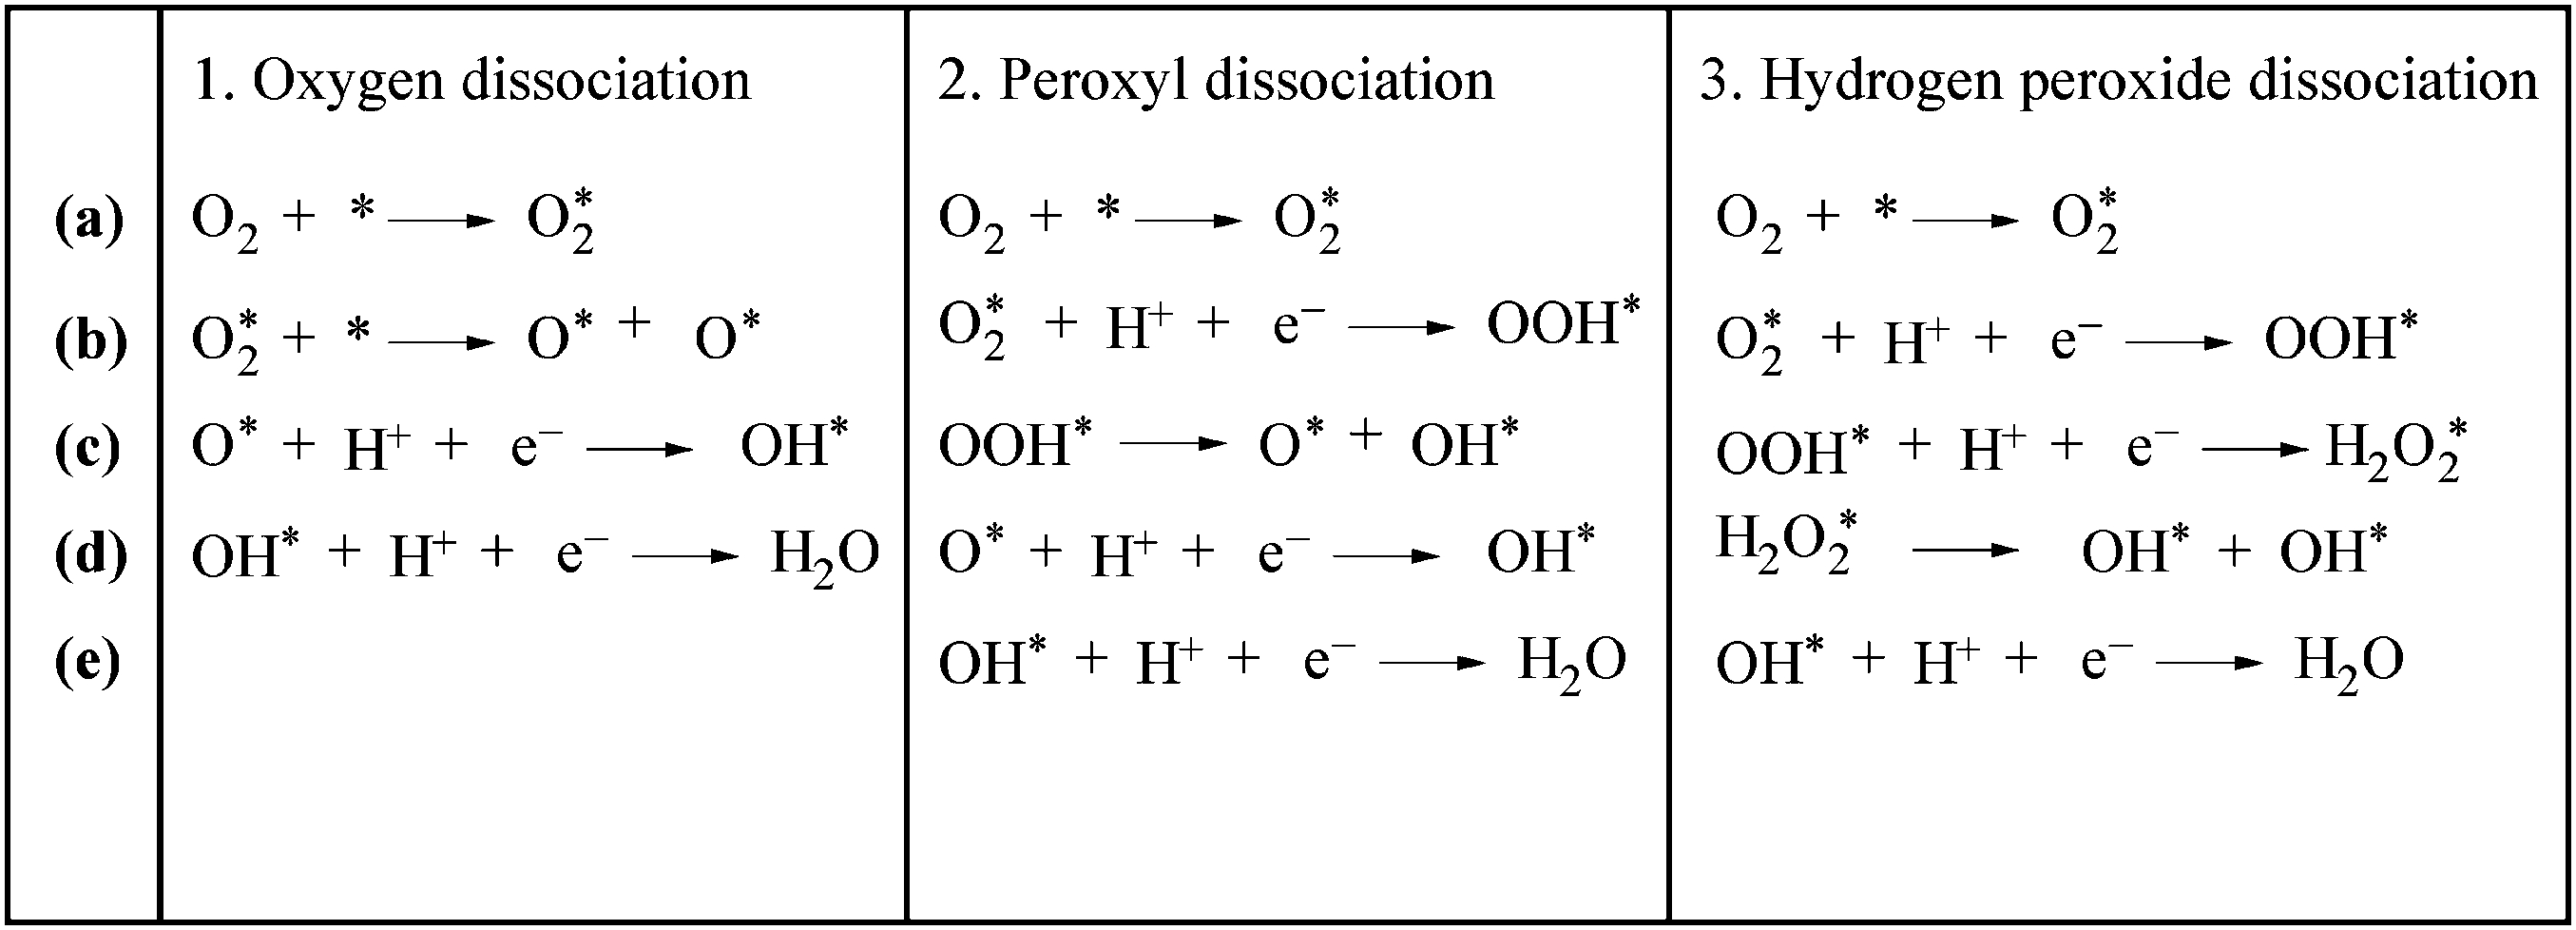

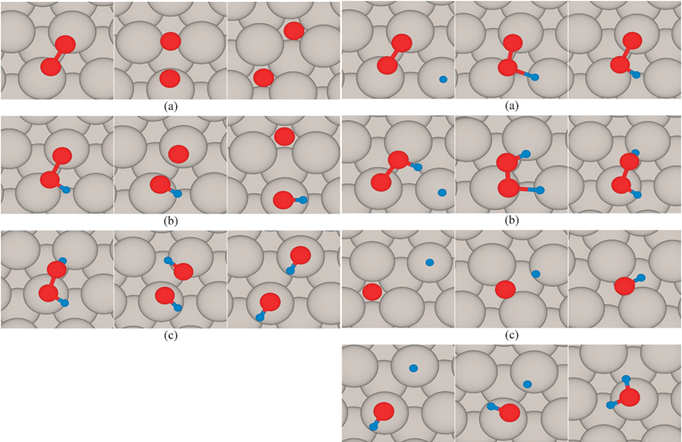

In [1]:
from atoms_model import *

In [2]:
# packages

import os
import math
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os import system
from os.path import join
from copy import deepcopy
from genericpath import exists

from ase import Atoms
from ase.io import read
from ase.visualize import view
from ase.build import add_adsorbate, molecule
# from ase.io.lammpsdata import write_lammps_data

In [3]:
# 设置全局字体为 Times New Roman
plt.rcParams["font.family"] = "serif"          # 使用衬线字体
plt.rcParams["font.serif"] = ["Times New Roman"]  # 指定 Times New Roman

plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["mathtext.it"] = "Times New Roman:italic"
plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

In [4]:
savepath = '.\\PtORR' # 保存路径根目录
input_dir = join(savepath, 'input') # 输入目录
output_dir = join(savepath, 'output') # 输出目录
md_dir = join(savepath, 'md') # 输出目录
create_folder(savepath, is_delete=False)
create_folder(input_dir, is_delete=False)
create_folder(output_dir, is_delete=False)
create_folder(md_dir, is_delete=False)

folder .\PtORR exists
folder .\PtORR\input exists
folder .\PtORR\output exists
folder .\PtORR\md exists


# Model

## Pt Bulk and slab

In [5]:

Pt_bulk_path = join(input_dir,'Pt_bulk_origin')
if os.path.exists(join(input_dir,'Pt_bulk_origin')):
    Pt_bulk = read_one_car(join(input_dir,'Pt_bulk_origin')) # 读取Pt_bulk数据并重复三次
    lattice = Pt_bulk.get_cell()[-1,-1]
else:
    lattice = 3.97 # 默认Pt晶格常数
lattice # 获得DFT计算的Pt晶格常数

3.967271975756752

In [6]:
# 创建Pt111slab模型
recreate = False  # 是否重复Pt_bulk
filename = join(input_dir, 'Pt.cfg')
if not exists(filename):
    print( f'File dose not exist: {filename}' )
    recreate = True
if recreate:
    try:
        del_file(filename)
        handle_line = f'atomsk --create fcc {lattice} Pt orient [-1-12] [1-10] [111] {filename}'
        print(handle_line)
        system(handle_line)
    except:
        print('atomsk is uninstall: websit\n atomsk.univ-lille.fr')

Pt_bulk = read(filename)
print(Pt_bulk.get_cell())
out_poscar(Pt_bulk, join(output_dir, 'Pt_bulk'))  # 输出POSCAR文件

Cell([4.85889601, 2.80528492, 6.87151663])
Folder .\PtORR\output\Pt_bulk already exists.


In [7]:
Pt_bulk = read_one_car(join(input_dir, 'Pt_bulk_copy'))  # 读取Pt_bulk数据
Pt_bulk_e = read_one_car(join(input_dir, 'Pt_bulk_copy'))  # 读取Pt_bulk数据

print(Pt_bulk.get_cell())

Cell([4.85889601, 2.80528492, 6.87151663])


In [8]:
Pt_slab = vac_ext(Pt_bulk, vacuum_h=25.0, ads_layer=1)  # 多加2个原子并添加真空层
Pt_slab = fix_layers_atoms(Pt_slab, {(-1,-1,-1):[-1,-2], (1,1,0):[-1,-2]},)  # 固定底部2层原子
out_poscar(Pt_slab, join(output_dir, 'Pt_slab'))  # 输出POSCAR文件

Folder .\PtORR\output\Pt_slab already exists.


In [9]:
Pt_slab = read_one_car(join(input_dir, 'Pt_slab_copy'))  # 读取Pt_slab数据
Pt_slab_e = read_one_car(join(input_dir, 'Pt_slab_copy'), car='OSZICAR')  # 读取Pt_slab数据

Pt_slab = fix_layers_atoms(Pt_slab, {(-1,-1,-1):[-1,-2]})
Pt_slab = Pt_slab.repeat((2,4,1))
Pt_slab_e = Pt_slab_e*4*4

E0 value: -1 F   -.46274982E+02


# O<sub>2</sub> dissociation

## O<sub>2</sub> adsorption

initial O2 positions:
 [[ 0.  -0.7  0. ]
 [ 0.   0.7  0. ]]
initial O2 positions:
 [[3.23926402 2.80528492 2.29050552]
 [3.23926402 5.61056984 2.29050552]]
Folder .\PtORR\output\O2_ads already exists.
Folder .\.\PtORR\output\O2_ads\is already exists.
Folder .\.\PtORR\output\O2_ads\fs already exists.


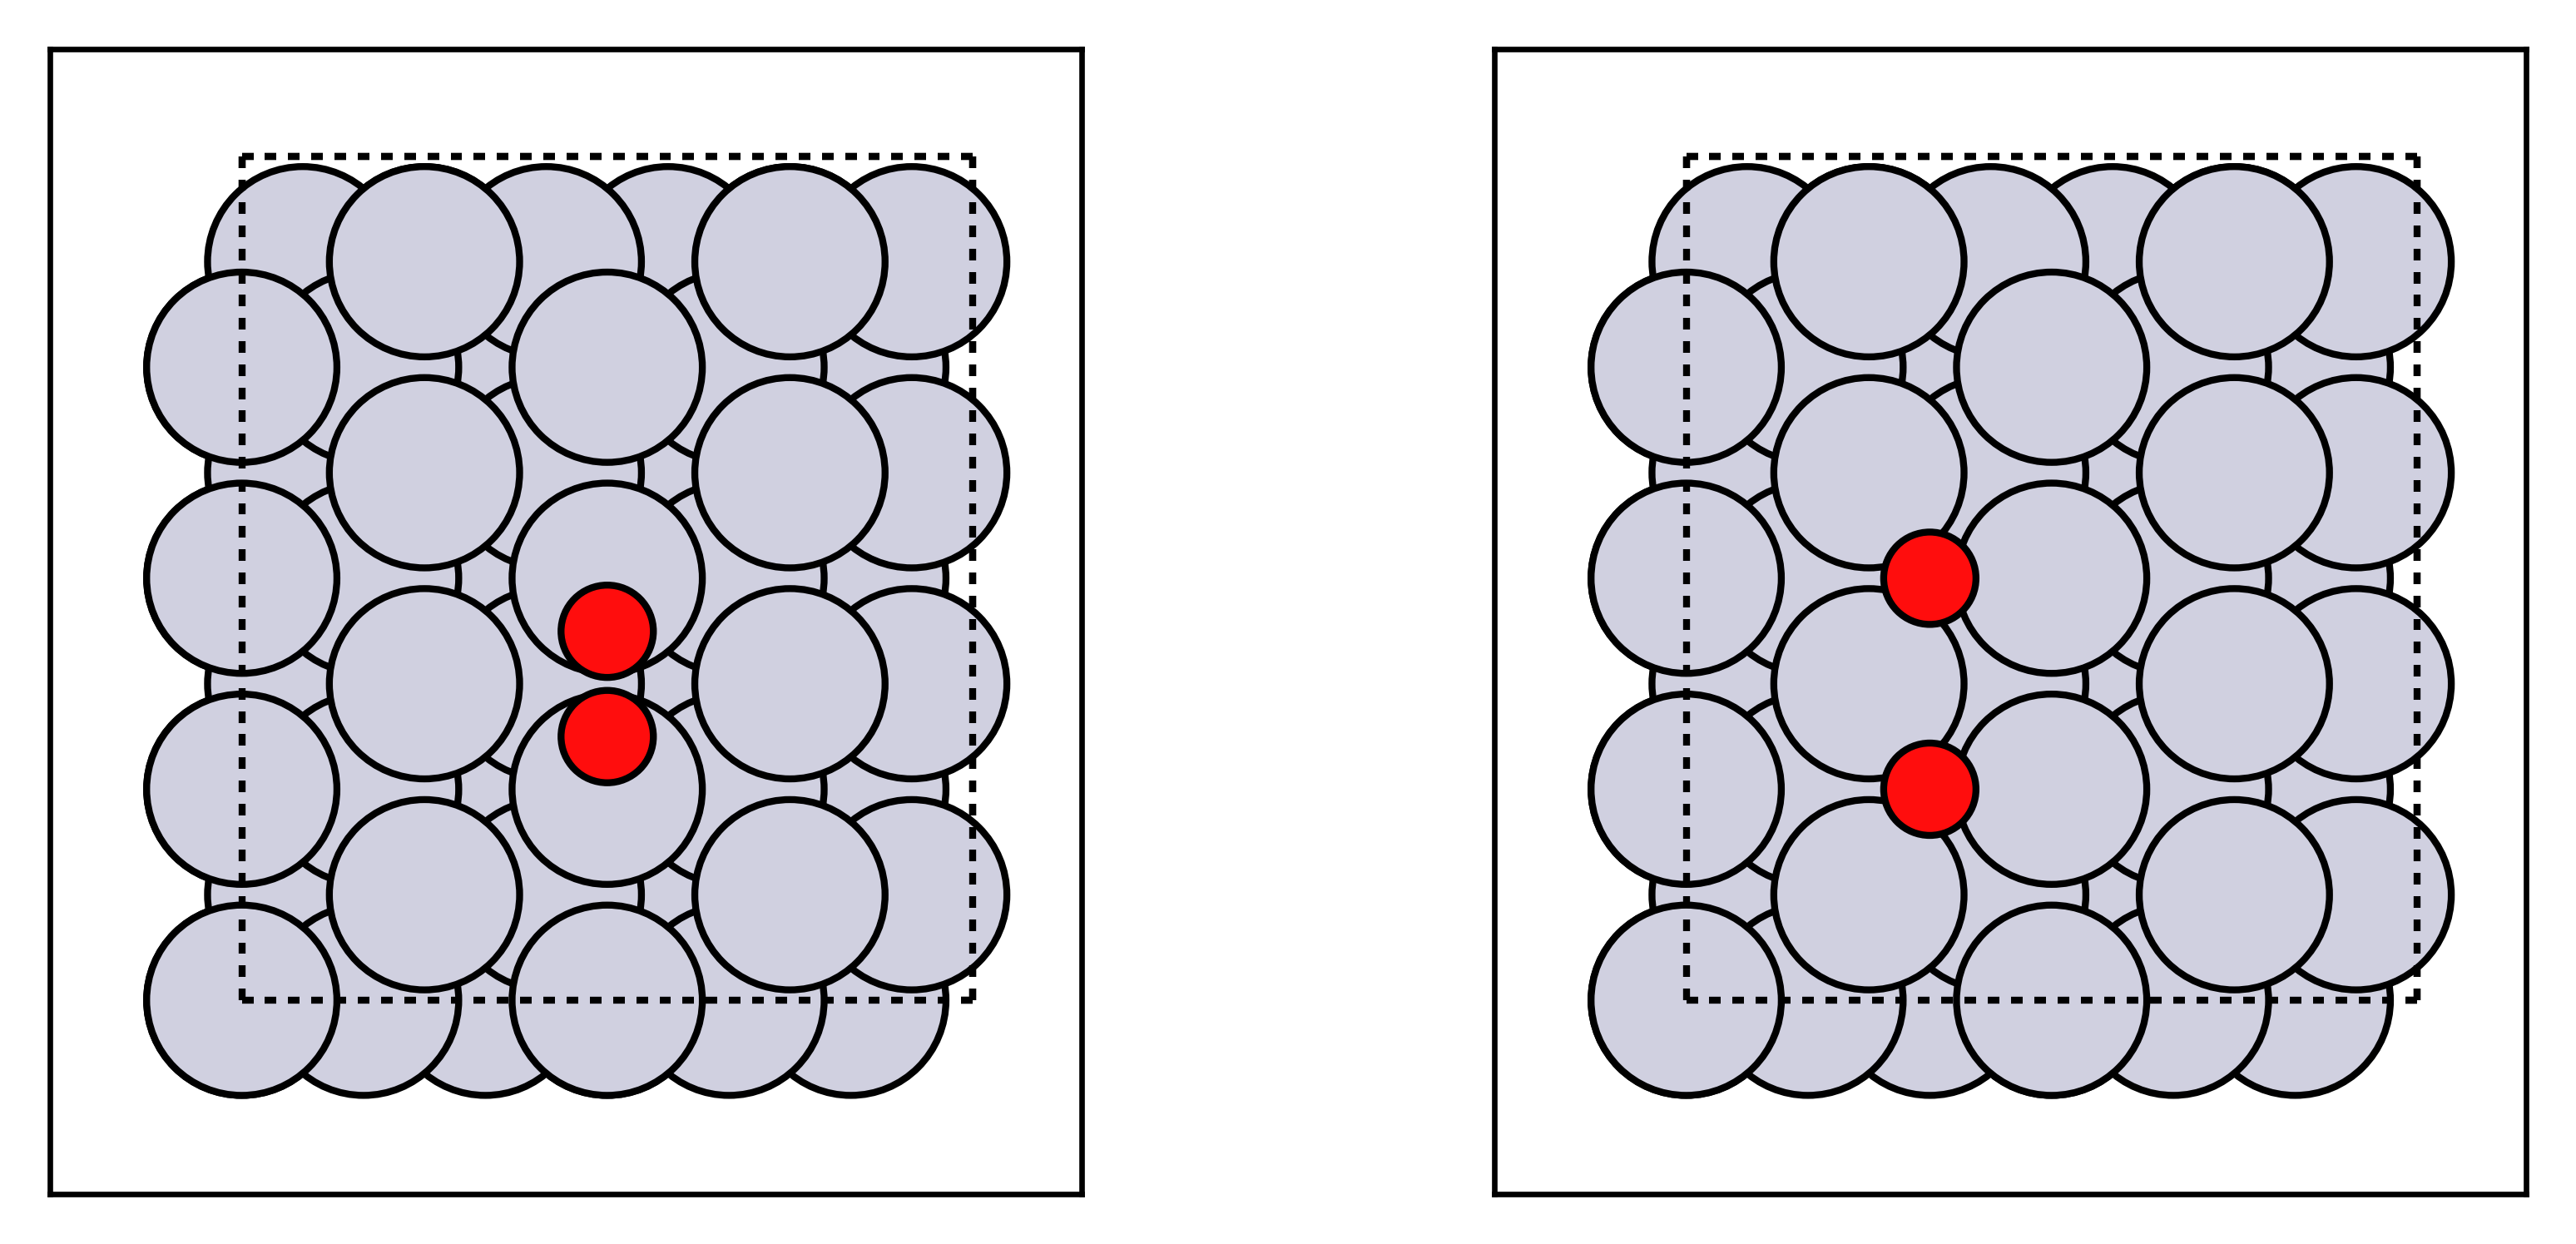

In [10]:
_, pos0 = get_location(Pt_slab, [2,1,-1])
_, pos1 = get_location(Pt_slab, [2,1,-1])
O2_pos= np.array([[.0, -0.7, .0], [.0, 0.7, .0]])  # O2分子位置
O2 = molecule('O2', positions=O2_pos)  # 创建O2分子

ads_pos = pos0[:2] - O2_pos[0,:2]
print('initial O2 positions:\n', O2.positions)
O2_ads0 = Pt_slab.copy()  # 氧分子吸附在Pt_slab上
add_adsorbate(O2_ads0, O2, height=2.0, position=ads_pos)


_, pos2 = get_location(Pt_slab, [1,1,1])
_, pos3 = get_location(Pt_slab, [1,2,1])
O2_pos= np.array([pos2, pos3])  # O2分子位置
O2 = molecule('O2', positions=O2_pos)  # 创建O2分子

ads_pos = (pos0[:2] + pos1[:2])/2 - O2_pos[0,:2]
print('initial O2 positions:\n', O2.positions)
O2_ads1 = Pt_slab.copy()  # 氧分子吸附在Pt_slab上
add_adsorbate(O2_ads1, O2, height=1.2, position=pos2[:2])


O2_ads = {'is':O2_ads0, 'fs':O2_ads1,}
out_car_list(O2_ads, join(output_dir, 'O2_ads'))  # 输出吸附结构
plot_top(list(O2_ads.values()),column=2, radii=0.93)

1st dict_keys(['fs', 'is'])
E0 value: -1 F   -.41742497E+03
E0 value: -1 F   -.41569426E+03
1st dict_keys(['fs', 'is'])


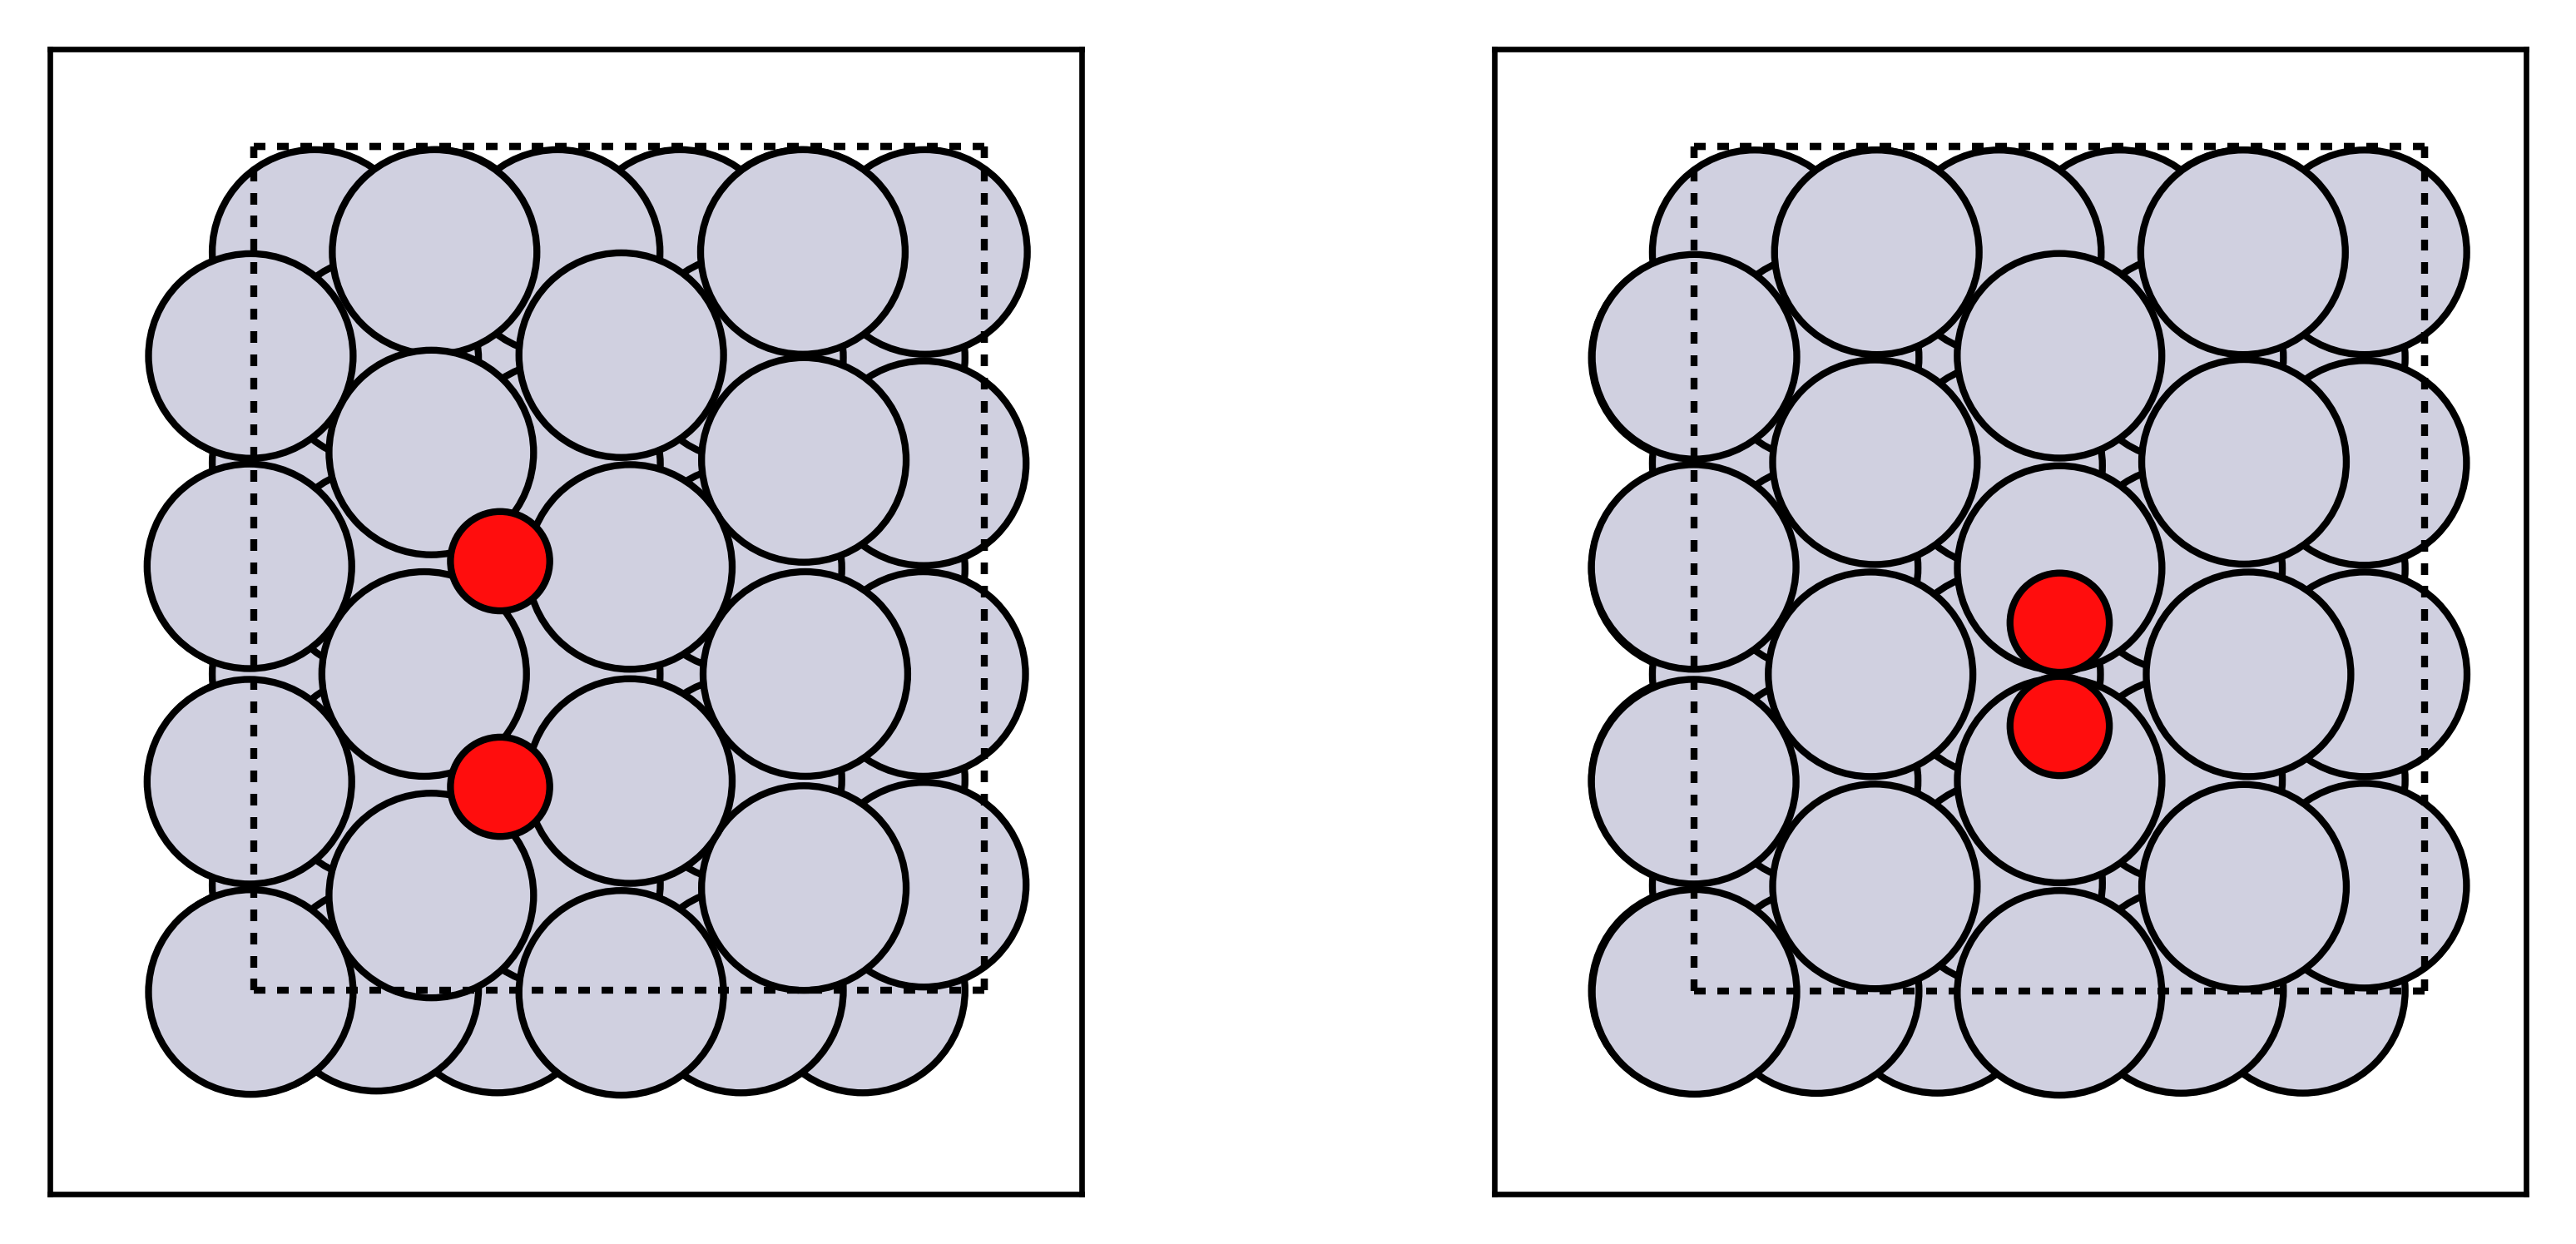

In [11]:
O2_ads_l, O2_ads_d = read_car(join(input_dir, 'O2_ads_copy'))
O2_ads_e_l, O2_ads_e_d = read_car(join(input_dir, 'O2_ads_copy'), car='OSZICAR')
plot_top(O2_ads_l, column=2)

## NEB of O2 dissociation

In [12]:
n_image = 1
ads_path =  join(input_dir, 'O2_ads_copy') # 存储初态和末态的地址 input_path
neb_path = join(output_dir,'neb_O2_diss') # 输出neb的地址 output_path
neb_l, neb_d = create_neb(ads_path, neb_path, n_mage_prepared=n_image, interpolation='idpp')

True
Folder .\PtORR\output\neb_O2_diss already exists.
delete .\PtORR\output\neb_O2_diss
folder '.\PtORR\output\neb_O2_diss' is created
.\PtORR\input\O2_ads_copy\is
Folder .\PtORR\output\neb_O2_diss already exists.
Folder .\.\PtORR\output\neb_O2_diss\00 already exists.
Folder .\.\PtORR\output\neb_O2_diss\01 already exists.
Folder .\.\PtORR\output\neb_O2_diss\02 already exists.
Ignore file: D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\output\neb_O2_diss\00\POSCAR
Ignore file: D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\output\neb_O2_diss\02\POSCAR
1st dict_keys(['00', '01', '02'])


Folder .\PtORR\output\neb_O2_diss\01 already exists.
1st dict_keys(['00', '01', '02'])


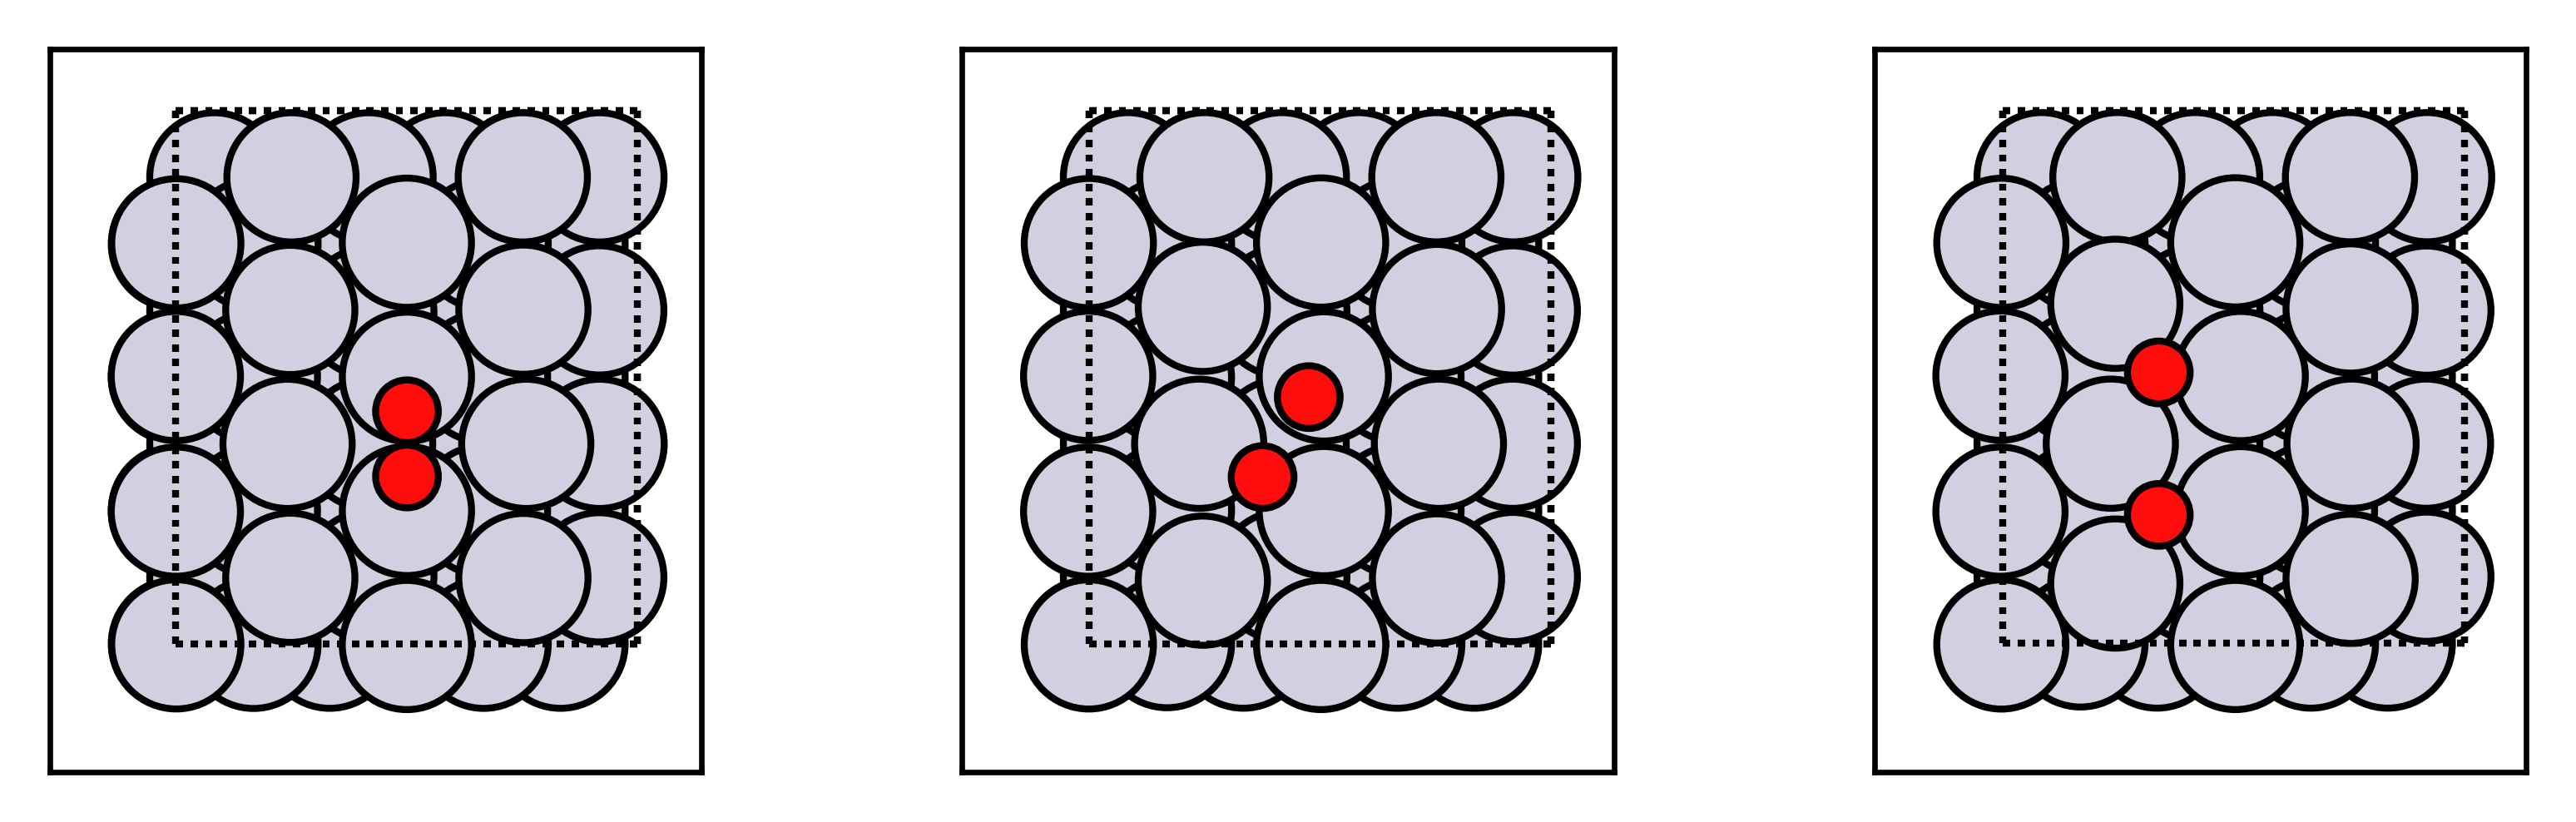

In [13]:
# 修正过渡态
tran = neb_l[1]
arg0, pos0 = get_location(Pt_slab, [2,2,-1])
arg1, pos1 = get_location(Pt_slab, [1,1,-1])
arg2, pos2 = get_location(Pt_slab, [2,1,-1])

pos3 = (pos1+pos2)/2
pos4 = pos3*0.2 + pos0*0.8

refer_pos = tran.get_positions()
refer_pos[-2,:2] = pos4[:2]
refer_pos[-2,-1] = neb_l[0].get_positions()[-1,-1]
refer_pos[-1,:2] = pos3[:2]
tran.set_positions(refer_pos)
n_transition = math.ceil(n_image/2)
out_poscar(tran,join(neb_path, f'0{n_transition}'))
neb_l, neb_d = read_car(neb_path, car='POSCAR')
plot_top(neb_l)

In [14]:
neb_copy_path = join(input_dir, 'neb_O2_diss_copy')
neb_l, neb_d = read_car(neb_copy_path)
neb_e_l, neb_e_d = read_car(neb_copy_path, car='OSZICAR')

1st dict_keys(['00', '01', '02'])
E0 value: -1 F   -.41569426E+03
E0 value: -1 F   -.41521947E+03
E0 value: -1 F   -.41742497E+03
1st dict_keys(['00', '01', '02'])


### dimer
When NEB convergence is difficult, use the Dimer method and select the configuration and further search for the transition state.\
收敛困难时，使用dimer方法，选择构型，进一步搜索过渡态

In [15]:
# n_transition = math.ceil(n_image/2)
n_transition = np.argmax(neb_e_l)
print(f'select the No.{n_transition} image as transition state')
transition = neb_l[n_transition]
transition = fix_layers_atoms(transition, fix_atoms={(-1,-1,-1):[-1,-2]})
# 字典的键(key)是固定的方向(负号表示不固定选择的原子，即反选)，值(value)是选择的原子(负号表示反向计数)
tran_dimer_path = join(output_dir, 'tran_dimer')
create_folder(tran_dimer_path)
out_poscar(transition, join(tran_dimer_path,'freq')) # 输出频率计算构型

select the No.1 image as transition state
folder .\PtORR\output\tran_dimer exists
Folder .\PtORR\output\tran_dimer\freq already exists.


In [16]:
frep_copy_path = join(input_dir, 'freq_copy')
concatenate_files(frep_copy_path) # 使用 Pymol 或其他软件进行频率分析
dimer_path = join(tran_dimer_path, 'dimer')
dimer_model = generate_dimer_poscar(frep_copy_path, dimer_path, fix_model=lambda m: fix_layers_atoms(m, fix_layers={(1,1,1):[0,1]}))

folder .\PtORR\output\tran_dimer\dimer exists

DONE!
Output file created: .\PtORR\output\tran_dimer\dimer\POSCAR
This can be used for dimer calculations.
Remember to rename it to POSCAR before running dimer jobs.
Highest frequency mode included: 314.79 cm^-1


In [17]:
dimer_copy_path = join(input_dir, 'dimer_copy')
neb_dimer_path = join(input_dir, 'neb_dimer')
shutil.copytree(neb_copy_path, neb_dimer_path, dirs_exist_ok=True)
shutil.copytree(dimer_copy_path, join(neb_dimer_path,'01'),dirs_exist_ok=True)

'.\\PtORR\\input\\neb_dimer\\01'

1st dict_keys(['00', '01', '02'])
E0 value: -1 F   -.41569426E+03
E0 value: -1 F   -.41524158E+03
E0 value: -1 F   -.41742497E+03
1st dict_keys(['00', '01', '02'])


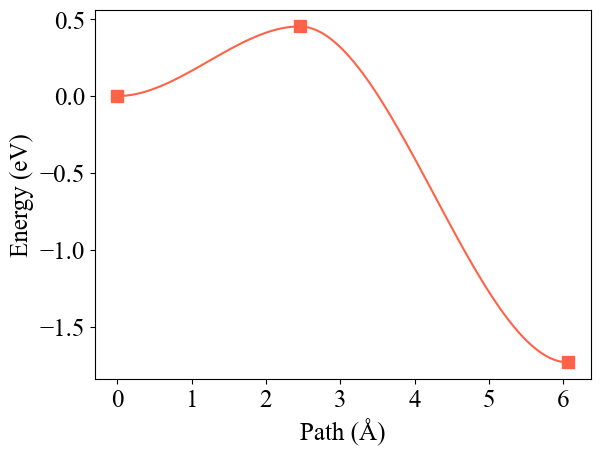

[ 0.       0.45268 -1.73071]


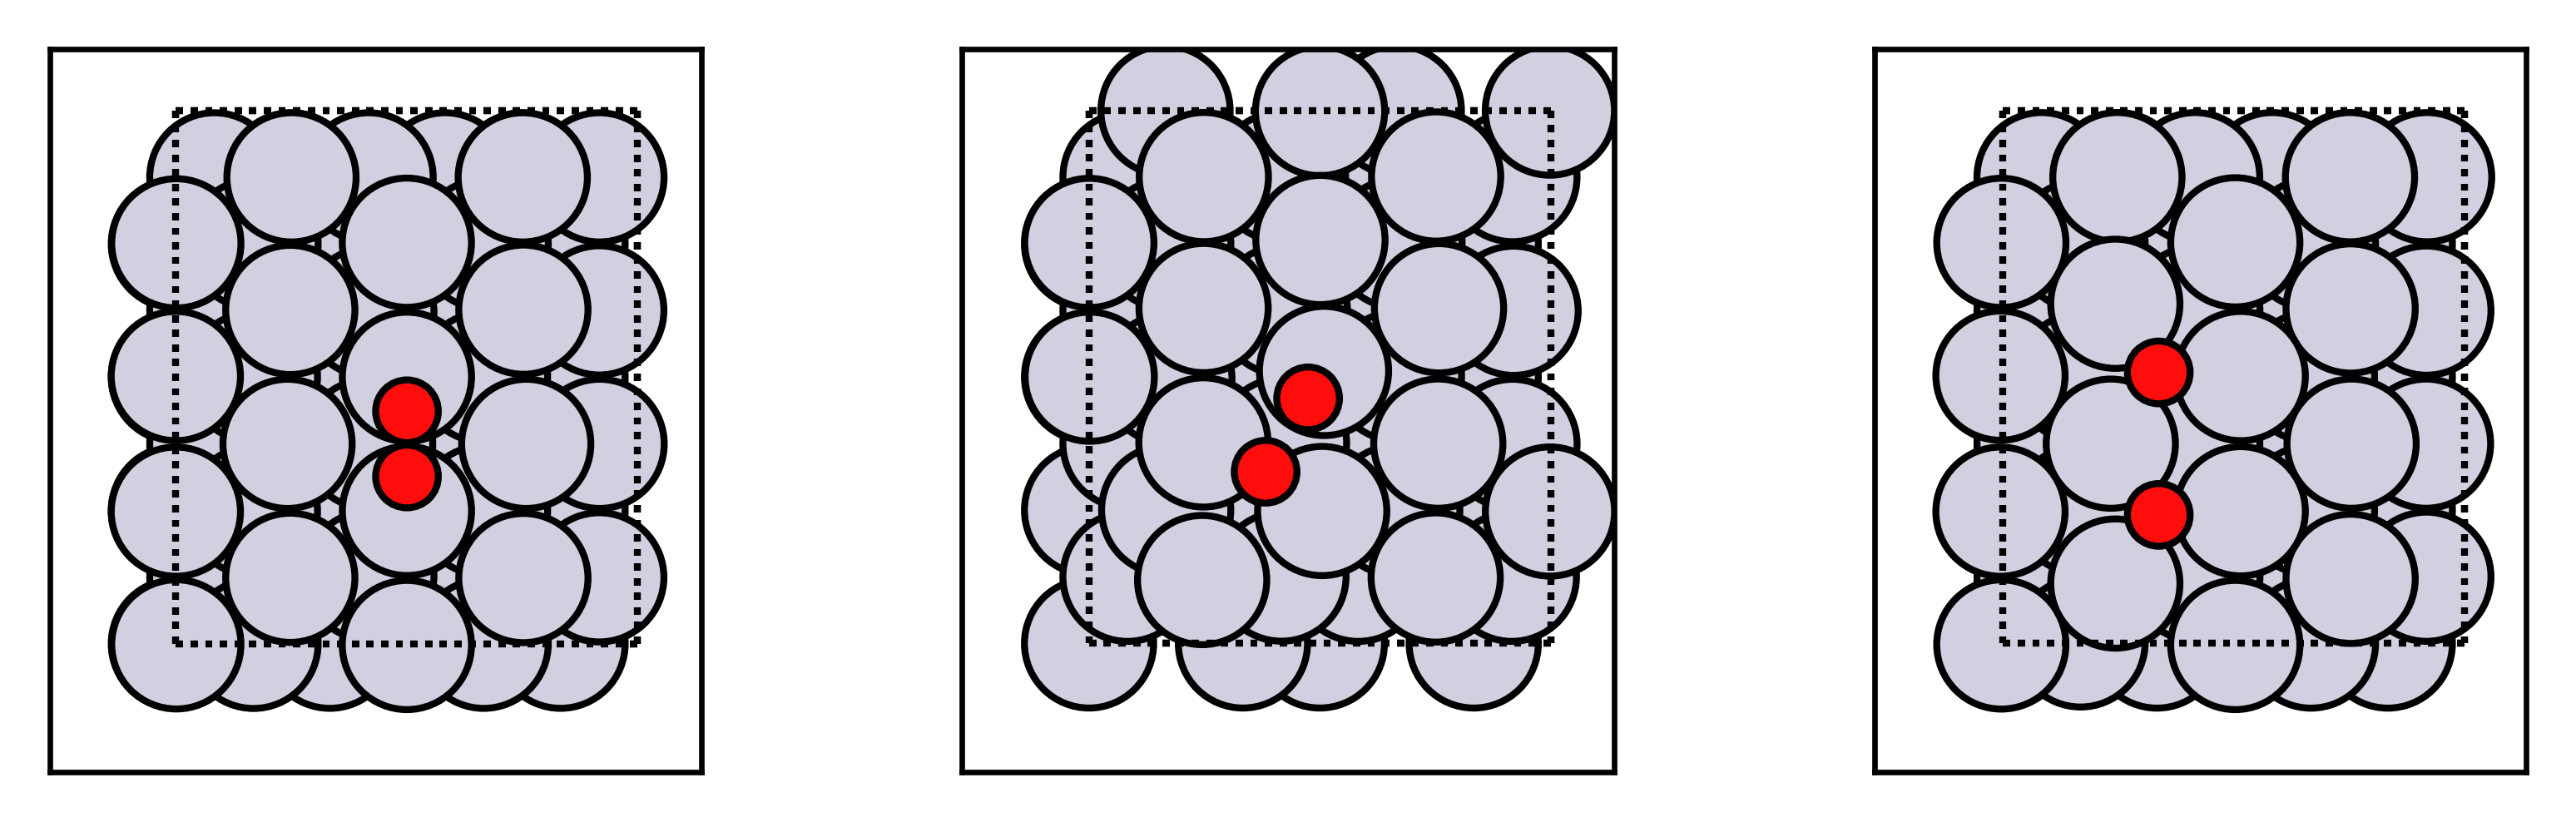

In [18]:
neb_l, neb_d = read_car(neb_dimer_path)
neb_e_l, neb_e_d = read_car(neb_dimer_path, car='OSZICAR')
dis_x = get_dist_list(neb_l)
neb_e_l = np.array(neb_e_l)
neb_e0_l = neb_e_l - neb_e_l[0]
x_interp1, y_interp1 = interpolate_plot(dis_x, neb_e0_l)
print(neb_e0_l)
plot_top(neb_l)

# Strain alter Energy

## strain

In [19]:
strain_symbal_dict = {'x':[1,0,0], 'y':[0,1,0]}
# 等三轴应变，y轴应变 和 z轴应变
positive_negativate = {'p':1, 'n':-1 }
max_strain = 0.02

strain_dict = {}
for stain_key in strain_symbal_dict:
    strain_symbal = strain_symbal_dict[stain_key]
    for pn_key in positive_negativate:
        pn_value = positive_negativate[pn_key]
        strain_ = strain_symbal.copy()
        key = stain_key+'_' + pn_key
        strain_dict[key] =  np.array(strain_)*max_strain/len(stain_key)*pn_value
print(strain_dict)

# strain bulk
strain_bulk = {}
for strain_key in strain_dict:
    strain = strain_dict[strain_key]
    adslab_value = Pt_bulk.copy()
    strain_bulk[strain_key], strain_value = opt_strain_F(adslab_value, strain)

strain_bulk_path = join(output_dir,'strain_bulk')
out_car_list(strain_bulk, path=strain_bulk_path)

{'x_p': array([0.02, 0.  , 0.  ]), 'x_n': array([-0.02, -0.  , -0.  ]), 'y_p': array([0.  , 0.02, 0.  ]), 'y_n': array([-0.  , -0.02, -0.  ])}
Folder .\PtORR\output\strain_bulk already exists.
Folder .\.\PtORR\output\strain_bulk\x_p already exists.
Folder .\.\PtORR\output\strain_bulk\x_n already exists.
Folder .\.\PtORR\output\strain_bulk\y_p already exists.
Folder .\.\PtORR\output\strain_bulk\y_n already exists.


In [20]:
# read strained bulk
strain_bulk_copy = join(input_dir,'strain_bulk_copy')
strain_bulk = read_car(strain_bulk_copy, car="CONTCAR")
strain_bulk_e = read_car(strain_bulk_copy, car="OSZICAR")

strain_bulk_e_d = strain_bulk_e[1]
strain_bulk_e_d['no_strain'] = Pt_bulk_e

for key, value in strain_bulk[1].items():
    s = cal_strain(Pt_bulk, value)
    print(s) # 检验应变

1st dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])
E0 value: -1 F   -.36552284E+02
E0 value: -1 F   -.36559981E+02
E0 value: -1 F   -.36551799E+02
E0 value: -1 F   -.36560890E+02
1st dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])
[[-0.02        0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.01250484]]
[[ 0.02        0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         -0.01215627]]
[[-1.11022302e-16  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.00000000e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.26805807e-02]]
[[-1.11022302e-16  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.00000000e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.23320224e-02]]


In [21]:
strain_slab = deepcopy(strain_bulk[1])
for key in strain_slab:
    refer_value = strain_slab[key]
    refer_value = vac_ext(refer_value, vacuum_h=25.0, ads_layer=1) # 多加2个原子并添加真空层
    refer_value =  fix_layers_atoms(refer_value, {(-1,-1,-1):[-1,-2], (1,1,0):[-1,-2]},) #固定底部2层原子
    strain_slab[key] = refer_value # 固定底部2层原子
out_car_list(strain_slab, path=os.path.join(output_dir,'strain_slab'))

Folder .\PtORR\output\strain_slab already exists.
Folder .\.\PtORR\output\strain_slab\x_n already exists.
Folder .\.\PtORR\output\strain_slab\x_p already exists.
Folder .\.\PtORR\output\strain_slab\y_n already exists.
Folder .\.\PtORR\output\strain_slab\y_p already exists.


In [22]:
_, strain_slab = read_car(os.path.join(input_dir,'strain_slab_copy'))
for key in strain_slab:
    strain_slab[key] = fix_layers_atoms(refer_value, {(-1,-1,-1):[-1,-2]})
    strain_slab[key] = strain_slab[key].repeat((2,4,1))
_, strain_slab_e = read_car(os.path.join(input_dir,'strain_slab_copy'), car='OSZICAR')
for key in strain_slab_e:
    strain_slab_e[key] = strain_slab_e[key]*2*4

for key, value in strain_slab.items():
    s = cal_strain(Pt_slab, value)
    print(s) # 检验应变

1st dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])
E0 value: -1 F   -.46405767E+02
E0 value: -1 F   -.46082183E+02
E0 value: -1 F   -.46407085E+02
E0 value: -1 F   -.46082144E+02
1st dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])
[[-1.11022302e-16  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.00000000e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.22044605e-16]]
[[-1.11022302e-16  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.00000000e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.22044605e-16]]
[[-1.11022302e-16  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.00000000e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.22044605e-16]]
[[-1.11022302e-16  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.00000000e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.22044605e-16]]


## strain alter neb
主要通过dimer方式搜索过渡态

In [23]:
adslab_dict ={'is':O2_ads_d['is'],
              'fs':O2_ads_d['fs'],}
strain_adslab = {}
for strain_key in strain_dict:
    strain = strain_dict[strain_key]
    strain_ = {}
    for adslab_key in adslab_dict.keys():
        adslab_value = adslab_dict[adslab_key].copy()
        # strain_adslab_key = f'{strain_key}_{adslab_key}'
        refer_value, strain_value = opt_strain_F(adslab_value, strain)
        value_pos = refer_value.get_positions()
        value_pos[:-2,-1] = strain_slab[strain_key].get_positions()[:,-1]
        # 保持底部原子xy位置不变,仅调整了z坐标
        refer_value.set_positions(value_pos)
        strain_[adslab_key] = refer_value
    strain_adslab[strain_key] = strain_
    print(strain_key)
    print(strain_value)
strain_adslab_path = join(output_dir,'strain_adslab')
out_car_list(strain_adslab, path=strain_adslab_path)

x_p
[[0.02 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
x_n
[[-0.02  0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]]
y_p
[[-1.11022302e-16  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.00000000e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
y_n
[[-1.11022302e-16  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.00000000e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Folder .\PtORR\output\strain_adslab already exists.
Folder .\.\PtORR\output\strain_adslab\x_p already exists.
Folder .\.\PtORR\output\strain_adslab\x_n already exists.
Folder .\.\PtORR\output\strain_adslab\y_p already exists.
Folder .\.\PtORR\output\strain_adslab\y_n already exists.


In [24]:
strain_adslab_copy_path = join(input_dir,'strain_adslab_copy')
strain_adslab_l, strain_adslab_d = read_cars(strain_adslab_copy_path)
strain_adslab_e_l, strain_adslab_e_d = read_cars(strain_adslab_copy_path,car='OSZICAR')

.\PtORR\input\strain_adslab_copy\CONTCARS.pkl
dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])
.\PtORR\input\strain_adslab_copy\OSZICARS.pkl
dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])


In [25]:
# n_transition = math.ceil(n_image/2)
n_transition = np.argmax(neb_e_l)
print(f'select the No.{n_transition} image as transition state')
transition = neb_l[n_transition]
transition = fix_layers_atoms(transition, fix_atoms={(-1,-1,-1):[-1,-2]})
# # 字典的键(key)是固定的方向(负号表示不固定选择的原子，即反选)，值(value)是选择的原子(负号表示反向计数)

strain_freq = deepcopy(strain_slab)
tran_relax = transition.get_positions()[:-2] - Pt_slab.get_positions() # 优化引起的无应变结构的坐标变化
for key, strain_value in strain_dict.items():
    strain_tran, s = opt_strain(transition.copy(), strain_value)
    pos = strain_tran.get_positions()
    refer_pos = strain_slab[key].get_positions()
    pos[:-2,-1] = refer_pos[:,-1] + tran_relax[:,-1] # 应变对应的左边变化 补充优化优化引起的变化
    refer_hight = np.max(refer_pos[:,-1]) - np.max(pos[:-2,-1]) # 表面高度变化
    pos[-2:,-1] += refer_hight # 补充表面高度变化
    strain_tran.set_positions(pos)
    strain_freq[key] = strain_tran
out_car_list(strain_freq, path=join(output_dir, 'strain_freq'))
# 需要检查频率计算的POSCAR是否只放松了反应的原子

select the No.1 image as transition state
Folder .\PtORR\output\strain_freq already exists.
Folder .\.\PtORR\output\strain_freq\x_n already exists.
Folder .\.\PtORR\output\strain_freq\x_p already exists.
Folder .\.\PtORR\output\strain_freq\y_n already exists.
Folder .\.\PtORR\output\strain_freq\y_p already exists.


In [26]:
strain_freq_copy_path = join(input_dir, 'strain_freq_copy')
strain_dimer_path = join(output_dir, 'strain_dimer')
_, strain_dimer = read_car(strain_freq_copy_path)
for key in strain_dimer.keys():
    freq_path = join(strain_freq_copy_path, key)
    dimer_path = join(strain_dimer_path,key)
    concatenate_files(freq_path) # 在原目录下生成了OUTCAR.out文件，可以进行频率分析
    dimer_model = generate_dimer_poscar(freq_path, dimer_path, fix_model=lambda m: fix_layers_atoms(m, fix_layers={(1,1,1):[0,1]}))

1st dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])
folder .\PtORR\output\strain_dimer\x_n exists

DONE!
Output file created: .\PtORR\output\strain_dimer\x_n\POSCAR
This can be used for dimer calculations.
Remember to rename it to POSCAR before running dimer jobs.
Highest frequency mode included: 380.59 cm^-1
folder .\PtORR\output\strain_dimer\x_p exists

DONE!
Output file created: .\PtORR\output\strain_dimer\x_p\POSCAR
This can be used for dimer calculations.
Remember to rename it to POSCAR before running dimer jobs.
Highest frequency mode included: 379.68 cm^-1
folder .\PtORR\output\strain_dimer\y_n exists

DONE!
Output file created: .\PtORR\output\strain_dimer\y_n\POSCAR
This can be used for dimer calculations.
Remember to rename it to POSCAR before running dimer jobs.
Highest frequency mode included: 391.25 cm^-1
folder .\PtORR\output\strain_dimer\y_p exists

DONE!
Output file created: .\PtORR\output\strain_dimer\y_p\POSCAR
This can be used for dimer calculations.
Remember to rename it to 

In [27]:
strain_neb_path = join(output_dir, 'strain_neb')
for key in strain_adslab_d.keys():
    print(join(strain_adslab_copy_path, key))
    ads_path = join(strain_adslab_copy_path, key) # 存储初态和末态的地址 input_path
    neb_path = join(strain_neb_path, key) # 输出neb的地址 output_path
    neb_l_i, neb_d_i  = create_neb(ads_path, neb_path, n_mage_prepared=1, interpolation='idpp')

strain_neb_l, strain_neb_d = read_cars(strain_neb_path)
strain_neb_e_l, strain_neb_e_d = read_cars(strain_neb_path, car='OSZICAR')

.\PtORR\input\strain_adslab_copy\x_n
True
Folder .\PtORR\output\strain_neb\x_n already exists.
delete .\PtORR\output\strain_neb\x_n
folder '.\PtORR\output\strain_neb\x_n' is created
.\PtORR\input\strain_adslab_copy\x_n\is
Folder .\PtORR\output\strain_neb\x_n already exists.
Folder .\.\PtORR\output\strain_neb\x_n\00 already exists.
Folder .\.\PtORR\output\strain_neb\x_n\01 already exists.
Folder .\.\PtORR\output\strain_neb\x_n\02 already exists.
Ignore file: D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\output\strain_neb\x_n\00\POSCAR
Ignore file: D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\output\strain_neb\x_n\02\POSCAR
1st dict_keys(['00', '01', '02'])
.\PtORR\input\strain_adslab_copy\x_p
True
Folder .\PtORR\output\strain_neb\x_p already exists.
delete .\PtORR\output\strain_neb\x_p
folder '.\PtORR\output\strain_neb\x_p' is created
.\PtORR\input\strain_adslab_copy\x_p\is
Folder .\PtORR\output\strain_neb\x_p already exists.
Fold

In [28]:
strain_dimer_copy_path = join(input_dir,'strain_dimer_copy')
_,strain_dimer_copy = read_car(strain_dimer_copy_path)
_,strain_dimer_e_d = read_car(strain_dimer_copy_path, car="OSZICAR")

for key in strain_neb_e_d.keys():
    strain_neb_e_d[key][f'0{n_transition}'] = strain_dimer_e_d[key]
    strain_neb_d[key][f'0{n_transition}'] = strain_dimer_copy[key]
strain_neb_e_d

1st dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])
E0 value: -1 F   -.41673827E+03
E0 value: -1 F   -.41327203E+03
E0 value: -1 F   -.41677809E+03
E0 value: -1 F   -.41323898E+03
1st dict_keys(['x_n', 'x_p', 'y_n', 'y_p'])


{'x_n': {'00': -417.19901, '01': -416.73827, '02': -418.82805},
 'x_p': {'00': -413.70732, '01': -413.27203, '02': -415.52431},
 'y_n': {'00': -417.30584, '01': -416.77809, '02': -418.87649},
 'y_p': {'00': -413.61474, '01': -413.23898, '02': -415.47854}}

In [29]:
# O_e = read_one_car(join(input,'O'), car='OSZICAR')
strain_dict['no_strain'] = np.array([.0,.0,.0])
strain_slab['no_strain'] = Pt_slab
strain_slab_e['no_strain'] = Pt_slab_e
strain_neb_d['no_strain'] = neb_d
strain_neb_e_d['no_strain'] = neb_e_d
strain_neb_e_d

{'x_n': {'00': -417.19901, '01': -416.73827, '02': -418.82805},
 'x_p': {'00': -413.70732, '01': -413.27203, '02': -415.52431},
 'y_n': {'00': -417.30584, '01': -416.77809, '02': -418.87649},
 'y_p': {'00': -413.61474, '01': -413.23898, '02': -415.47854},
 'no_strain': {'00': -415.69426, '01': -415.24158, '02': -417.42497}}

In [30]:
all_neb = {}
for key in strain_dict.keys():
    print(key)
    neb_models = strain_neb_d[key]
    neb_dist = get_dist_list(list(neb_models.values()))
    neb_x = np.array([x/neb_dist[-1] for x in neb_dist])
    neb_e = list(strain_neb_e_d[key].values())
    neb_e = np.array(neb_e) - strain_slab_e[key]

    symbel, direction = key.split('_')
    if direction == 'n':
        direction = -1
    elif direction == 'p':
        direction = 1
    else:
        direction = 0
    strain_value = direction*max_strain

    neb_data = NEB_path_e(
    name=key,
    path_points=np.array(neb_x),
    energy_values=np.array(neb_e),
    models=neb_models,  # 两个模型
    strain=strain_dict[key],
    strain_value=strain_value,
    strain_symbel=symbel,
    )
    all_neb[key] = neb_data
all_neb

x_p
x_n
y_p
y_n
no_strain


{'x_p': <EnergyProfile: x_p with 3 points,3 models,  is barrier: 0.435,fs barrier: 2.252>,
 'x_n': <EnergyProfile: x_n with 3 points,3 models,  is barrier: 0.461,fs barrier: 2.090>,
 'y_p': <EnergyProfile: y_p with 3 points,3 models,  is barrier: 0.376,fs barrier: 2.240>,
 'y_n': <EnergyProfile: y_n with 3 points,3 models,  is barrier: 0.528,fs barrier: 2.098>,
 'no_strain': <EnergyProfile: no_strain with 3 points,3 models,  is barrier: 0.453,fs barrier: 2.183>}

In [31]:
E_neb = {}
for key, x_e in all_neb.items():

    x = x_e.strain_value
    e1 =  x_e.get_is_barrier()
    e2 =  x_e.get_fs_barrier()
    symbel = x_e.strain_symbel
    if symbel not in E_neb.keys() and symbel != 'no' :
        E_neb[symbel] = [[x, e1, e2]]
    elif symbel in E_neb.keys():
        E_neb[symbel].append([x, e1, e2])
    else:  # symbel == 'no' 的情况
        # 为所有已有键的值添加数据
        for k in E_neb:
            E_neb[k].append([x, e1, e2])
E_neb

{'x': [[0.02, 0.43529000000000906, 2.2522800000000416],
  [-0.02, 0.46073999999998705, 2.089780000000019],
  [0.0, 0.45267999999998665, 2.1833899999999744]],
 'y': [[0.02, 0.375759999999957, 2.239559999999983],
  [-0.02, 0.5277499999999691, 2.0983999999999696],
  [0.0, 0.45267999999998665, 2.1833899999999744]]}

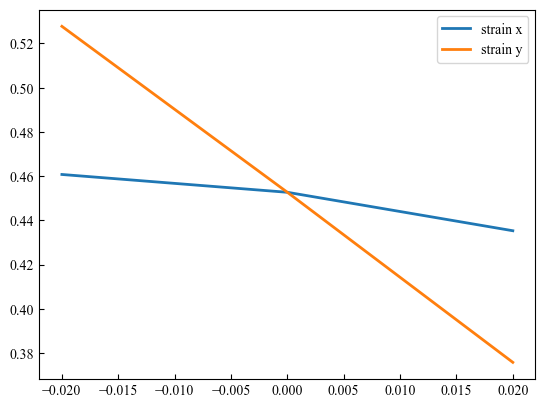

In [32]:
for key, value in E_neb.items():
    value = np.array(value)
    value = value[value[:, 0].argsort()]
    E_neb[key] = value

# 绘图
# colors = ['b', 'r']  # 假设最多两条线
for key, value in E_neb.items():
    plt.plot(value[:,0],
             value[:,1],
            #  marker='o' if idx % 2 == 0 else 's',  # 偶数索引使用圆点，奇数索引使用方块
            #  linestyle='-' if idx % 2 == 0 else '--',  # 偶数索引使用实线，奇数索引使用虚线
             linewidth = 2,
             markersize = 6,
             label=f'strain {key}')  # 根据实际情况修改标签
plt.legend()
plt.show()

## MD calculation

In [33]:
lattice_md = 3.9474 # 默认Pt晶格常数
# 创建Pt111slab模型
recreate = False  # 是否重复Pt_bulk

filename = join(md_dir, 'Pt_md.cfg')
if not exists(filename):
    print( f'File dose not exist: {filename}' )
    recreate = True

if recreate:
    try:
        del_file(filename)
        handle_line = f'atomsk --create fcc {lattice_md} Pt orient [-1-12] [1-10] [111] {filename}'
        print(handle_line)
        system(handle_line)
    except:
        print('atomsk is uninstall: websit\n atomsk.univ-lille.fr')
Pt_bulk_md = read(filename).repeat((8,16,4))

print(Pt_bulk_md.get_cell())
bulk_md_path = join(md_dir, 'bulk')
create_folder(bulk_md_path, is_delete=False)
filename = join(bulk_md_path,'lammps.data')
write_lammps_data(filename, Pt_bulk_md, atom_style="charge")

Cell([38.67646328, 44.65973296, 27.34838944])
folder .\PtORR\md\bulk exists


In [34]:
bulk_copy_path = join(md_dir, 'bulk_copy')
bulk_copy = read_one_car(bulk_copy_path, car=lambda x : read_lammps_onedata(x, style='charge'))
Pt_bulk_md.set_cell(bulk_copy.get_cell(), scale_atoms=True) # 设置Pt_bulk_md的晶胞参数
print(Pt_bulk_md.get_cell())

Cell([38.675839478873655, 44.65901265650376, 27.34794834599373])


In [35]:
Pt_slab_md = build_suface(Pt_bulk_md, cell_z=60.0)  # 添加真空层
Pt_slab_md.set_constraint()
slab_md_path = join(md_dir, 'slab')
create_folder(slab_md_path, is_delete=False)
write_lammps_onedata(slab_md_path, Pt_slab_md)  # 写入lammps数据文件

folder .\PtORR\md\slab exists


In [36]:
slab_copy_path = join(md_dir, 'slab_copy')
slab_copy = read_one_car(slab_copy_path, car=read_lammps_onedata)
slab_copy_e = read_one_car(slab_copy_path, car=extract_last_toteng)  # 提取最后一步的总能量值
Pt_slab_md.set_cell(slab_copy.get_cell(), scale_atoms=True) # 设置Pt_slab_md的晶胞参数
slab_copy, slab_copy_e,

(Atoms(symbols='Pt3072', pbc=True, cell=[38.69394839813112, 44.67992515978285, 60.0], id=..., initial_charges=..., masses=..., mmcharges=..., momenta=..., travel=..., type=...),
 -400424.86)

In [37]:
_, pos0 = get_location(Pt_slab_md, [8,7,-1])
_, pos1 = get_location(Pt_slab_md, [8,8,-1])
O2_pos= np.array([[.0, -0.7, .0], [.0, 0.7, .0]])  # O2分子位置
O2 = molecule('O2', positions=O2_pos)  # 创建O2分子

ads_pos = pos0[:2] - O2_pos[0,:2]
print('initial O2 positions:\n', O2.positions)
O2_ads0 = Pt_slab_md.copy()  # 氧分子吸附在Pt_slab上
add_adsorbate(O2_ads0, O2, height=2.0, position=ads_pos)

_, pos2 = get_location(Pt_slab_md, [8,7,-3])
_, pos3 = get_location(Pt_slab_md, [8,8,-3])
O2_pos= np.array([pos2, pos3])  # O2分子位置
O2 = molecule('O2', positions=O2_pos)  # 创建O2分子

print('initial O2 positions:\n', O2.positions)
O2_ads1 = Pt_slab_md.copy()  # 氧分子吸附在Pt_slab上
add_adsorbate(O2_ads1, O2, height=1.22, position=pos2[:2])

O2_ads_md = {'is':O2_ads0, 'fs':O2_ads1}
out_car_list(O2_ads_md, join(md_dir, 'O2_ads'),out_format=write_lammps_onedata)  # 输出吸附结构

initial O2 positions:
 [[ 0.  -0.7  0. ]
 [ 0.   0.7  0. ]]
initial O2 positions:
 [[19.3469742  19.54746726 20.51096126]
 [19.3469742  22.33996258 20.51096126]]
Folder .\PtORR\md\O2_ads already exists.


In [38]:
O2_ads_md_l, O2_ads_md_d = read_car(join(md_dir, 'O2_ads_copy'),car=lambda p :get_dump_files(join(p,'results'))[-1])
O2_ads_md_e_l, O2_ads_md_e_d = read_car(join(md_dir, 'O2_ads_copy'),car=extract_last_toteng)

D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\md\O2_ads_copy\fs\results\dump.neb.0.text
D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\md\O2_ads_copy\fs\results\dump.neb.36.text
D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\md\O2_ads_copy\is\results\dump.neb.0.text
D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\md\O2_ads_copy\is\results\dump.neb.100.text
D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\md\O2_ads_copy\is\results\dump.neb.200.text
D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\md\O2_ads_copy\is\results\dump.neb.222.text
1st dict_keys(['fs', 'is'])
1st dict_keys(['fs', 'is'])


### MD NEB of O2 dissociation

In [39]:
# 修正过渡态
tran = O2_ads0
arg0, pos0 = get_location(Pt_slab_md, [8,8,-1])
arg1, pos1 = get_location(Pt_slab_md, [7,7,-1])
arg2, pos2 = get_location(Pt_slab_md, [8,7,-1])

pos3 = (pos1+pos2)/2
pos4 = pos3*0.2 + pos0*0.8

refer_pos = tran.get_positions()
refer_pos[-2,:2] = pos4[:2]
refer_pos[-2,-1] = O2_ads_md_d['is'].get_positions()[-1,-1]
refer_pos[-1,:2] = pos3[:2]
tran.set_positions(refer_pos)


In [40]:
neb_path = join(md_dir, 'O2_neb')
create_folder(neb_path, is_delete=False)
neb_refer_path = join(neb_path, 'refer')
create_folder(neb_refer_path, is_delete='True')

write_lammps_onedata(neb_refer_path, O2_ads_md_d['is'], style='charge') # is model
filename = join(neb_refer_path, f'lammps.3.data')
write_refer_atoms(O2_ads_md_d['fs'], outpath=filename, ads_num=[-2,-1]) # fs model
filename = join(neb_refer_path, f'lammps.2.data')
write_refer_atoms(tran, outpath=filename, ads_num=[-2,-1]) # fs model

folder .\PtORR\md\O2_neb exists
True


Folder .\PtORR\md\O2_neb\refer already exists.
delete .\PtORR\md\O2_neb\refer
folder '.\PtORR\md\O2_neb\refer' is created


D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\md\O2_neb\results\dump.neb.1.text
D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\md\O2_neb\results\dump.neb.2.text
D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\md\O2_neb\results\dump.neb.3.text
D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\md\O2_neb\results\dump.neb.1.text
D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\md\O2_neb\results\dump.neb.2.text
D:\OneDrive\OneDrive - stu.xjtu.edu.cn\python\program\strain\strain\PtORR\md\O2_neb\results\dump.neb.3.text
reaction_coordinate de
0 0
0.398 10.171
1.000 -13.898


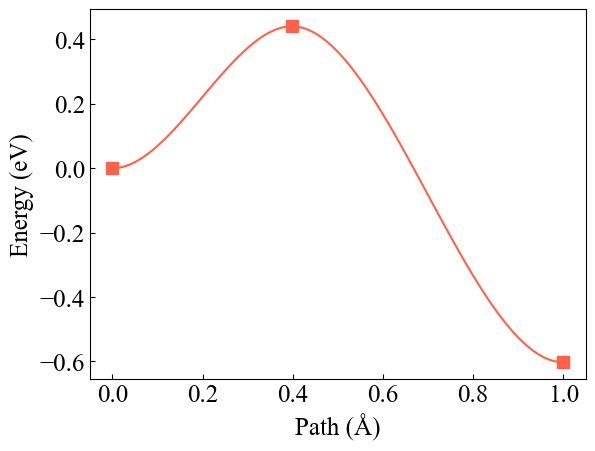

In [41]:
kcal_mol2eV = 0.04336 # kcal/mol to eV

neb_md_models = get_dump_files(join(neb_path,'results'))
neb_md_x, neb_md_e = get_md_neb_result(neb_path)
neb_md_e = kcal_mol2eV*neb_md_e
x_interp1, y_interp1 = interpolate_plot(neb_md_x, neb_md_e)

### neb f
再进行结构优化，目的是为了获得0时间步的受力

In [42]:
for i in range(len(neb_md_models)):
    md_model = neb_md_models[i]
    value_pos = md_model.get_positions()
    refer_pos = O2_ads0.get_positions()
    num = [-1,-2]
    refer_pos[num] = value_pos[num]
    md_model = O2_ads0.copy()
    md_model.set_positions(refer_pos) # 将非扩散原子恢复到原坐标
    neb_md_models[i] = md_model

neb_f_path = join(md_dir, 'O2_neb_f')
create_folder(neb_f_path, is_delete=False)
neb_refer_path = join(neb_f_path, 'refer')
create_folder(neb_refer_path, is_delete='True')
write_lammps_onedata(neb_refer_path, neb_md_models[0],style='charge') # is model
for i in range(len(neb_md_models)):
    print(i)
    filename = join(neb_refer_path, f'lammps.{i+1}.data')
    write_refer_atoms(neb_md_models[i], outpath=filename, ads_num=[-2,-1]) # each image

folder .\PtORR\md\O2_neb_f exists
True
Folder .\PtORR\md\O2_neb_f\refer already exists.
delete .\PtORR\md\O2_neb_f\refer
folder '.\PtORR\md\O2_neb_f\refer' is created
0
1
2


In [43]:
kcal_mol2eV = 0.04336 # kcal/mol to eV

In [57]:
md_neb = join(neb_f_path,'results')
is_model = read_lammps_onedata(md_neb, dump_fielname='dump.neb.1.text', format='lammps-dump-text')
ts_model = read_lammps_onedata(md_neb, dump_fielname='dump.neb.2.text', format='lammps-dump-text')
fs_model = read_lammps_onedata(md_neb, dump_fielname='dump.neb.3.text', format='lammps-dump-text')

is_eigen_force = -extract_atoms_data(join(md_neb,'dump.force.1.xyz'), order=0)[:,5:] # 本征位力
ts_eigen_force = -extract_atoms_data(join(md_neb,'dump.force.2.xyz'), order=0)[:,5:] # 需要取负号
fs_eigen_force = -extract_atoms_data(join(md_neb,'dump.force.3.xyz'), order=0)[:,5:]

is_eigen_stress = -extract_atoms_data(join(md_neb,'dump.stress.1.xyz'), order=0)[:,5:] # 本征应力
ts_eigen_stress = -extract_atoms_data(join(md_neb,'dump.stress.2.xyz'), order=0)[:,5:] # 需要取负号
fs_eigen_stress = -extract_atoms_data(join(md_neb,'dump.stress.3.xyz'), order=0)[:,5:]

is_eigen_force_field = covert6to3d(is_eigen_force)
ts_eigen_force_field = covert6to3d(ts_eigen_force)
fs_eigen_force_field = covert6to3d(fs_eigen_force)

is_eigen_stress_field = covert6to3d(is_eigen_stress)*0.1 # bar to MPa
ts_eigen_stress_field = covert6to3d(ts_eigen_stress)*0.1
fs_eigen_stress_field = covert6to3d(fs_eigen_stress)*0.1

print(is_eigen_force_field[-1])
print(ts_eigen_force_field[-1])
print(fs_eigen_force_field[-1])

[[-1122650. -1024340.  -454132.]
 [-1024340. -4650730.  -710514.]
 [ -454132.  -710514.  -217380.]]
[[-2881670.   590568.  -232729.]
 [  590568. -1476130.  -400410.]
 [ -232729.  -400410. -2320300.]]
[[ 1.22821e+05 -3.38529e+03 -1.28218e+04]
 [-3.38529e+03 -8.32861e+06  1.04683e+06]
 [-1.28218e+04  1.04683e+06 -1.26199e+06]]


In [59]:
view(fs_model)

<Popen: returncode: None args: ['c:\\Users\\lenovo\\.conda\\envs\\ase_model\...>

$\sigma _{xx}$
$\sigma _{yy}$
$\sigma _{zz}$


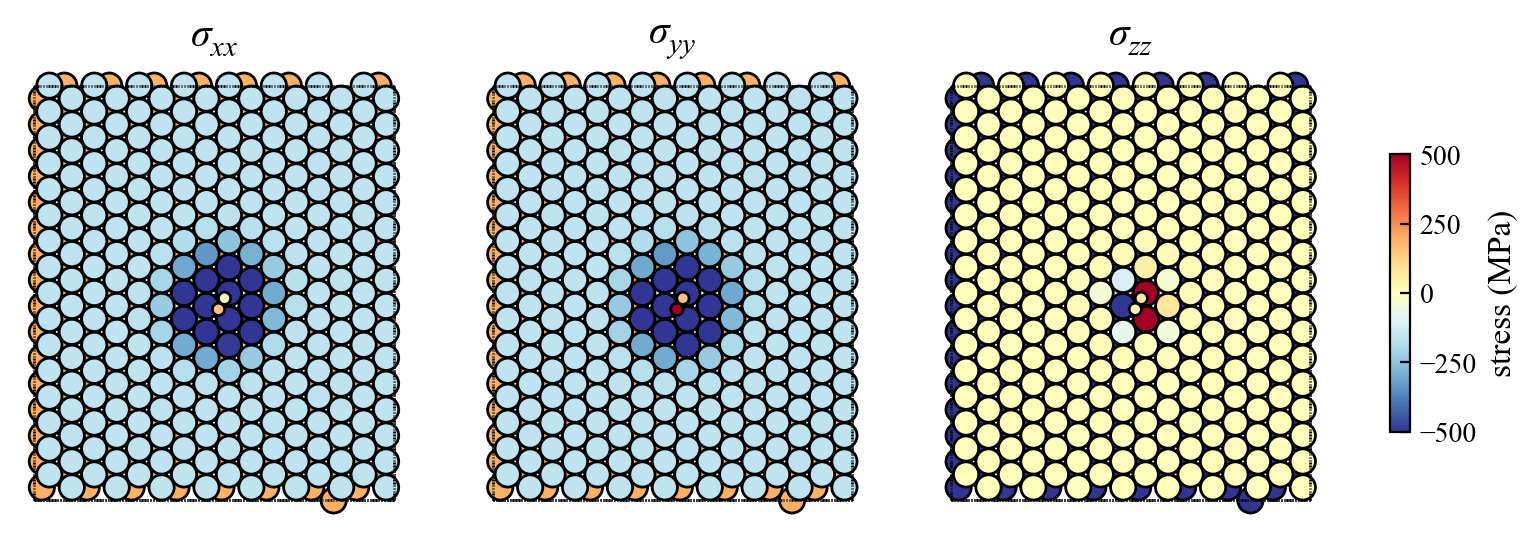

In [45]:
visiual_atoms_strain_3d(is_model, is_eigen_stress_field, input_range=[-5E2, 5E2], type='stress', units='MPa',layers=20)

$\sigma _{xx}$
$\sigma _{yy}$
$\sigma _{zz}$


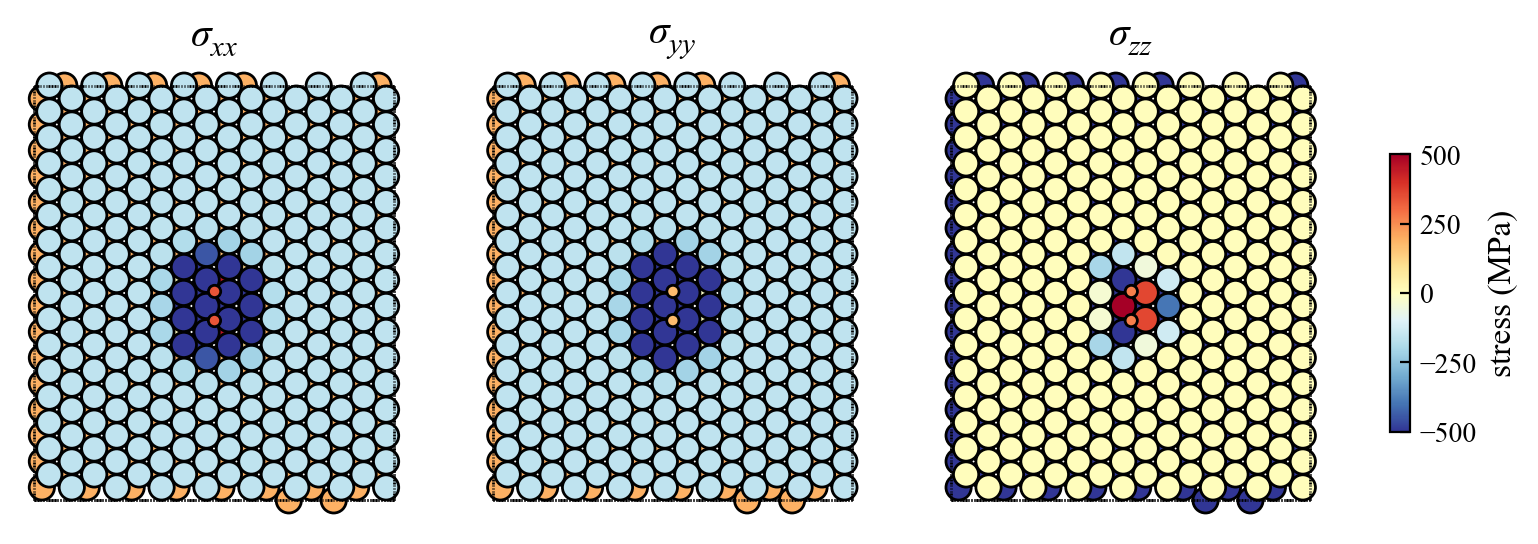

In [46]:
visiual_atoms_strain_3d(ts_model, ts_eigen_stress_field, input_range=[-5E2, 5E2], type='stress', units='MPa',layers=20)

$W _{xx}$
$W _{yy}$
$W _{zz}$


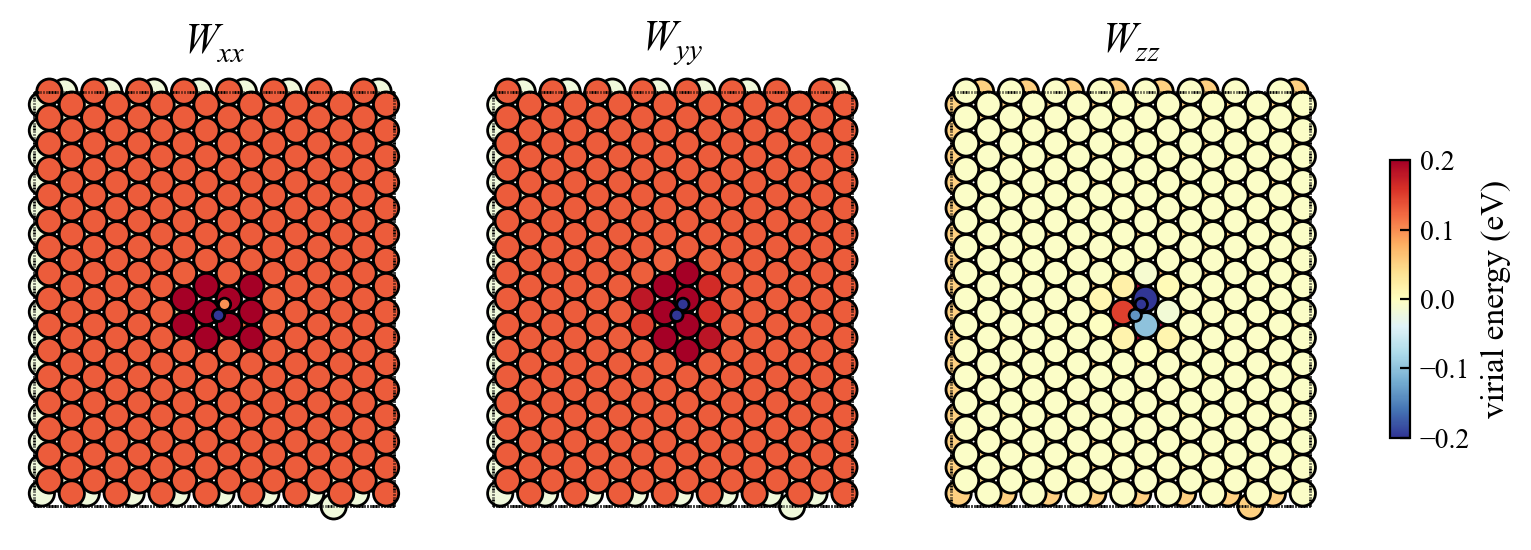

In [47]:
visiual_atoms_strain_3d(is_model, is_eigen_force_field*6.32421e-7, input_range=[-2e-1, 2e-1], type='virial energy', units='eV',layers=20)

$W _{xx}$
$W _{yy}$
$W _{zz}$


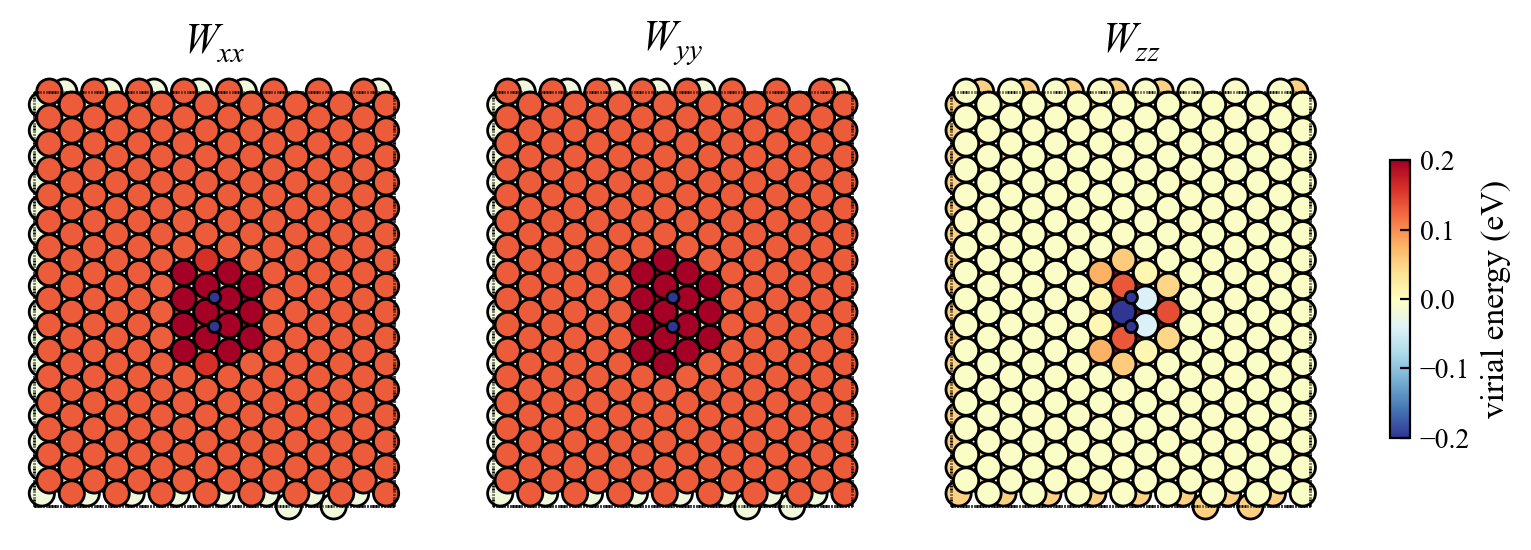

In [48]:
visiual_atoms_strain_3d(ts_model, ts_eigen_force_field*6.32421e-7, input_range=[-2e-1, 2e-1], type='virial energy', units='eV',layers=20)

In [52]:
# 初态的本征应力，和过渡态的本征应力, 已经乘了夹杂体积
is_x = sum(is_eigen_force_field[-2:, 0, 0])
is_y = sum(is_eigen_force_field[-2:, 1, 1])

ts_x = sum(ts_eigen_force_field[-2:, 0, 0])
ts_y = sum(ts_eigen_force_field[-2:, 1, 1])

In [55]:
-(ts_x - is_x)

4795322.0

In [56]:
-(ts_y - is_y)

-3654450.0

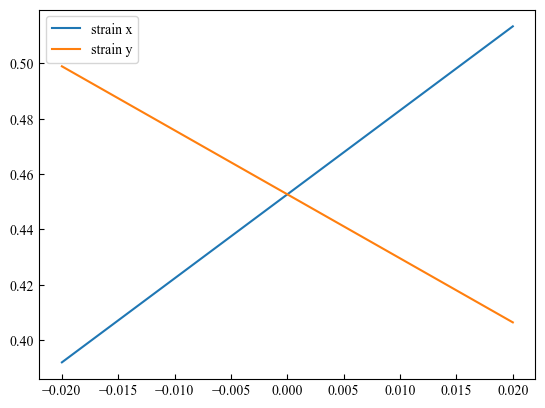

In [53]:


x_predict = np.array([-(ts_x - is_x) *max_strain *6.32421e-7 *i for i in range(-1,2)]) + max(neb_e0_l)
y_predict = np.array([-(ts_y - is_y) *max_strain *6.32421e-7 *i for i in range(-1,2)]) + max(neb_e0_l)

plt.figure()
plt.plot(np.arange(-1,2)*max_strain,x_predict, label='strain x')
plt.plot(np.arange(-1,2)*max_strain,y_predict, label='strain y')
plt.legend()
plt.show()